# KSAMDS: Data Analysis & Visualization Notebook

This notebook connects to a PostgreSQL instance hosting the **KSAMDS** (Knowledge, Skills, Abilities, Functions, Tasks) schema and provides comprehensive data analysis and visualizations.

**What you'll get:**
- Core entity counts across all KSAMDS dimensions (Knowledge, Skills, Abilities, Functions, Tasks, Occupations)
- Occupation linkage analysis showing how many occupations are connected to each KSAFT entity type
- Inferred relationship analysis displaying machine-learning generated connections between:
  - Knowledge ↔ Skills
  - Knowledge ↔ Functions  
  - Skills ↔ Abilities
  - Abilities ↔ Tasks
  - Functions ↔ Tasks
- Core-dimension relationship analysis showing how dimensional attributes (type, level, basis, etc.) are distributed across core entities
- Standardized bar chart visualizations with consistent formatting and proper label spacing

## 1) Install dependencies

In [1]:
# If running in a new environment, uncomment to install dependencies.
# You can safely re-run this cell.
%pip install psycopg2-binary SQLAlchemy pandas matplotlib networkx python-dotenv


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 2) Imports & Configuration

In [2]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import networkx as nx

load_dotenv()

# -------------------------------
# Connection configuration
# -------------------------------
DB_HOST = os.getenv("PGHOST", "localhost")
DB_PORT = os.getenv("PGPORT", "5432")
DB_USER = os.getenv("PGUSER", "postgres")
DB_PASS = os.getenv("PGPASSWORD", "8086")
DB_NAME = os.getenv("PGDATABASE", "ksamds")
DB_SCHEMA = os.getenv("PGSCHEMA", "ksamds")  # default schema name from SQL file

# Compose SQLAlchemy URL
db_url = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

print("Connecting to:", db_url.replace(DB_PASS, "<hidden>"))
engine = create_engine(db_url, pool_pre_ping=True, pool_recycle=3600)

# Helper to run SQL and get DataFrame
def run_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    with engine.begin() as conn:
        return pd.read_sql(text(query), conn, params=params)

# Utility to ensure schema-qualified names are easy to format
def t(name: str) -> str:
    return f"{DB_SCHEMA}.{name}"

Connecting to: postgresql+psycopg2://postgres:<hidden>@localhost:5432/ksamds


In [3]:
with engine.begin() as conn:
    conn.exec_driver_sql(f"SET search_path TO {DB_SCHEMA}, public;")

In [4]:
chk = run_sql("""
SELECT table_schema, table_name
FROM information_schema.tables
WHERE table_schema NOT IN ('pg_catalog','information_schema')
ORDER BY table_schema, table_name;
""")
chk

,table_schema,table_name
0,ksamds,ability
1,ksamds,ability_basis
2,ksamds,ability_level
3,ksamds,ability_task
4,ksamds,ability_type
5,ksamds,basis_dim
6,ksamds,certification
7,ksamds,cognitive_dim
8,ksamds,education_level
9,ksamds,environment_dim


## 3) Core entity counts

In [5]:
# Count records in each core entity table
tables = ["knowledge", "skill", "ability", "function", "task", "occupation"]
counts = {}

for tbl in tables:
    try:
        df = run_sql(f"SELECT COUNT(*) AS n FROM {t(tbl)}")
        counts[tbl] = int(df.loc[0, "n"])
    except Exception as e:
        counts[tbl] = f"error: {e}"

# Create DataFrame and display results
counts_df = pd.DataFrame(list(counts.items()), 
                        columns=["table", "row_count"]).sort_values("table")
display(counts_df)

,table,row_count
2,ability,50
3,function,40
0,knowledge,33
5,occupation,1016
1,skill,34
4,task,17538


### Bar chart: core entity counts

<Figure size 1000x600 with 0 Axes>

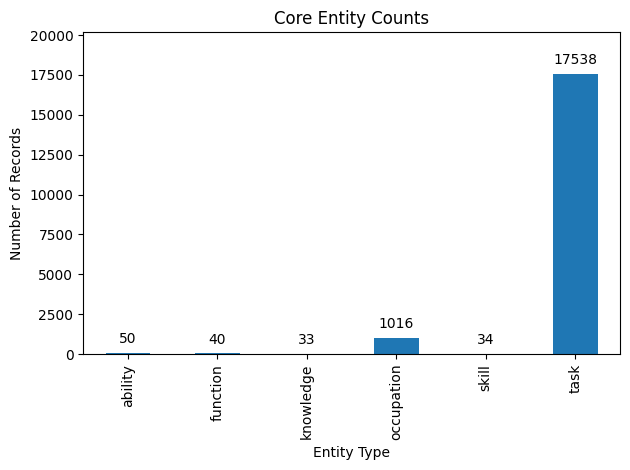

In [6]:
# Create bar chart for core entity counts
if isinstance(counts.get("knowledge"), str):
    print("Skipping plot because counts failed (likely missing schema or connection).")
else:
    plt.figure(figsize=(10, 6))
    ax = counts_df.plot(kind="bar", x="table", y="row_count", legend=False)
    
    # Add value labels on top of each bar
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')
    
    # Add space above bars and format chart
    max_count = counts_df['row_count'].max()
    ax.set_ylim(0, max_count * 1.15)
    
    plt.title("Core Entity Counts")
    plt.xlabel("Entity Type")
    plt.ylabel("Number of Records")
    plt.tight_layout()
    plt.show()

## 4) Occupations relation with KSAFT counts

,entity,linked_occupations
2,ability,893
3,function,894
0,knowledge,887
1,skill,884
4,task,923


<Figure size 1000x600 with 0 Axes>

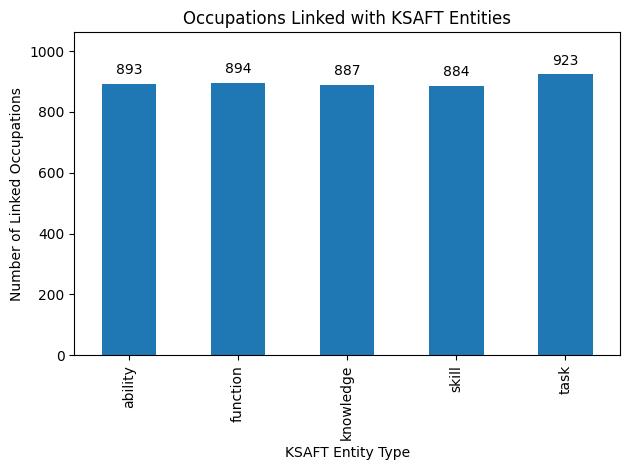

In [7]:
# Count occupations linked to each KSAFT entity type
try:
    occ_ksaft_counts = {}
    for entity in ["knowledge", "skill", "ability", "function", "task"]:
        bridge_table = f"occupation_{entity}"
        df = run_sql(f"SELECT COUNT(DISTINCT occupation_id) AS n FROM {t(bridge_table)}")
        occ_ksaft_counts[entity] = int(df.loc[0, "n"])
    
    occ_ksaft_df = pd.DataFrame(list(occ_ksaft_counts.items()), 
                                columns=["entity", "linked_occupations"]).sort_values("entity")
    display(occ_ksaft_df)
    
except Exception as e:
    print("Skipping Occupation-KSAFT counts due to error:", e)
    occ_ksaft_df = None

# Create bar chart for occupation-KSAFT linkages
if occ_ksaft_df is not None:
    plt.figure(figsize=(10, 6))
    ax = occ_ksaft_df.plot(kind="bar", x="entity", y="linked_occupations", legend=False)
    
    # Add value labels on top of each bar
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')
    
    # Add space above bars and format chart
    max_count = occ_ksaft_df['linked_occupations'].max()
    ax.set_ylim(0, max_count * 1.15)
    
    plt.title("Occupations Linked with KSAFT Entities")
    plt.xlabel("KSAFT Entity Type")
    plt.ylabel("Number of Linked Occupations")
    plt.tight_layout()
    plt.show()

## 5) KSAMDS Multi-dimensional Inferred Relations

In [8]:
# Count inferred relationships between KSAMDS entities
inferred_relation_counts = {}
relation_tables = [
    "ability_task",
    "function_task", 
    "knowledge_function",
    "knowledge_skill",
    "skill_ability"
]

for rel_table in relation_tables:
    try:
        df = run_sql(f"SELECT COUNT(*) AS n FROM {t(rel_table)}")
        inferred_relation_counts[rel_table] = int(df.loc[0, "n"])
    except Exception as e:
        inferred_relation_counts[rel_table] = f"error: {e}"

# Create DataFrame and display results
inferred_counts_df = pd.DataFrame(list(inferred_relation_counts.items()), 
                                  columns=["relation", "count"]).sort_values("relation")
display(inferred_counts_df)

,relation,count
0,ability_task,1250
1,function_task,400
2,knowledge_function,660
3,knowledge_skill,495
4,skill_ability,340


<Figure size 1000x600 with 0 Axes>

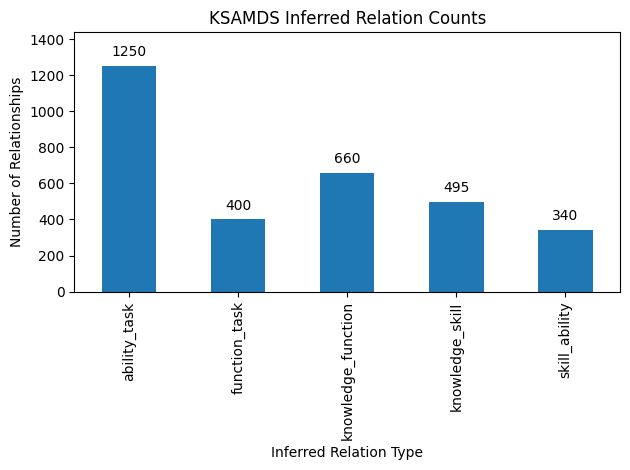

In [9]:
# Create bar chart for inferred relationship counts
plt.figure(figsize=(10, 6))
ax = inferred_counts_df.plot(kind="bar", x="relation", y="count", legend=False)

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

# Add space above bars and format chart
max_count = inferred_counts_df['count'].max()
ax.set_ylim(0, max_count * 1.15)

plt.title("KSAMDS Inferred Relation Counts")
plt.xlabel("Inferred Relation Type")
plt.ylabel("Number of Relationships")
plt.tight_layout()
plt.show()

## 6) Core-Dimension Tables Relation

In [10]:
# Count dimension records linked to each core entity type
dimension_core_tables = [
    "knowledge_type", "knowledge_basis", "knowledge_level",
    "skill_type", "skill_basis", "skill_level",
    "ability_type", "ability_basis", "ability_level",
    "function_physicality", "function_cognitive", "function_env",
    "task_mode", "task_env", "task_type"
]

dimension_core_counts = {}
for dim_table in dimension_core_tables:
    try:
        df = run_sql(f"SELECT COUNT(*) AS n FROM {t(dim_table)}")
        dimension_core_counts[dim_table] = int(df.loc[0, "n"])
    except Exception as e:
        dimension_core_counts[dim_table] = f"error: {e}"

# Create DataFrame and display results
dimension_counts_df = pd.DataFrame(list(dimension_core_counts.items()), 
                                   columns=["dimension_table", "row_count"]).sort_values("dimension_table")

# Extract dimension name from table name for clarity
dimension_counts_df["dimension_name"] = dimension_counts_df["dimension_table"].apply(lambda x: x.split("_")[-1])

# Extract core entity type from table name for clarity
dimension_counts_df["core_entity"] = dimension_counts_df["dimension_table"].apply(lambda x: x.split("_")[0])

display(dimension_counts_df)

,dimension_table,row_count,dimension_name,core_entity
7,ability_basis,84,basis,ability
8,ability_level,121,level,ability
6,ability_type,50,type,ability
10,function_cognitive,0,cognitive,function
11,function_env,0,env,function
9,function_physicality,0,physicality,function
1,knowledge_basis,54,basis,knowledge
2,knowledge_level,98,level,knowledge
0,knowledge_type,33,type,knowledge
4,skill_basis,60,basis,skill


In [11]:
# Sum counts of each common dimension_name
summed_dimension_counts = dimension_counts_df.groupby("dimension_name")["row_count"].sum().reset_index()
summed_dimension_counts = summed_dimension_counts.sort_values("dimension_name")
display(summed_dimension_counts)

,dimension_name,row_count
0,basis,198
1,cognitive,0
2,env,0
3,level,285
4,mode,0
5,physicality,0
6,type,117


In [12]:
pivot_df = dimension_counts_df.pivot(index="dimension_name", columns="core_entity", values="row_count").fillna(0)
display(pivot_df)

core_entity,ability,function,knowledge,skill,task
dimension_name,,,,,
basis,84.0,0.0,54.0,60.0,0.0
cognitive,0.0,0.0,0.0,0.0,0.0
env,0.0,0.0,0.0,0.0,0.0
level,121.0,0.0,98.0,66.0,0.0
mode,0.0,0.0,0.0,0.0,0.0
physicality,0.0,0.0,0.0,0.0,0.0
type,50.0,0.0,33.0,34.0,0.0


<Figure size 1000x600 with 0 Axes>

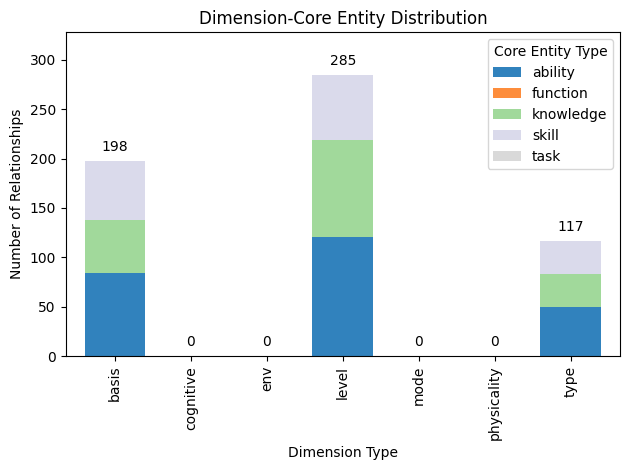

In [13]:
# Create stacked bar chart for dimension-core entity distribution
plt.figure(figsize=(10, 6))
ax = pivot_df.plot(kind="bar", stacked=True, colormap="tab20c", width=0.8)

# Add value labels on top of each bar (total count)
for i, row in summed_dimension_counts.iterrows():
    ax.annotate(str(int(row["row_count"])), 
                (i, row["row_count"]),
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

# Add space above bars and format chart
max_count = summed_dimension_counts['row_count'].max()
ax.set_ylim(0, max_count * 1.15)

plt.title("Dimension-Core Entity Distribution")
plt.xlabel("Dimension Type")
plt.ylabel("Number of Relationships")
plt.legend(title="Core Entity Type")
plt.tight_layout()
plt.show()